# Segmenting remote sensing imagery with box prompts

In [ ]:
# %pip install segment-geospatial

In [43]:
import leafmap
from samgeo import tms_to_geotiff
from samgeo import SamGeo

## Create an interactive map

In [44]:
m = leafmap.Map(center=[48.367462,10.939471], zoom=18, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[48.367462, 10.939471], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

## Download a sample image

Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map

In [45]:
bbox = m.user_roi_bounds()
if bbox is None:
    bbox = [10.939471 - 0.001, 48.367462 - 0.001, 10.939471 + 0.001, 48.367462 + 0.001]

In [43]:
image = "Images/Image_bbox3.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=19, source="Satellite", overwrite=True)

Downloaded image 01/20
Downloaded image 02/20
Downloaded image 03/20
Downloaded image 04/20
Downloaded image 05/20
Downloaded image 06/20
Downloaded image 07/20
Downloaded image 08/20
Downloaded image 09/20
Downloaded image 10/20
Downloaded image 11/20
Downloaded image 12/20
Downloaded image 13/20
Downloaded image 14/20
Downloaded image 15/20
Downloaded image 16/20
Downloaded image 17/20
Downloaded image 18/20
Downloaded image 19/20
Downloaded image 20/20
Saving GeoTIFF. Please wait...
Image saved to Images/Image_bbox3.tif


You can also use your own image. Uncomment and run the following cell to use your own image.

In [47]:
image = "Images/Image_bbox3.tif"

Display the downloaded image on the map.

In [48]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(bottom=23225670.0, center=[48.367462, 10.939471], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Initialize SAM class

The initialization of the LangSAM class might take a few minutes. The initialization downloads the model weights and sets up the model for inference.

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

Set `automatic=False` to disable the `SamAutomaticMaskGenerator` and enable the `SamPredictor`.

In [49]:
sam = SamGeo(
    model_type="vit_h",
    automatic=False,
    sam_kwargs=None,
)

Specify the image to segment. 

In [50]:
sam.set_image(image)

Display the map. Use the drawing tools to draw some rectangles around the features you want to extract, such as trees, buildings.

In [51]:
m

Map(bottom=23225670.0, center=[48.367462, 10.939471], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Create bounding boxes

If no rectangles are drawn, the default bounding boxes will be used as follows:

In [52]:
boxes = m.user_rois


# if m.user_rois is not None:
#     boxes = m.user_rois
# else:
#     boxes = [
#         [-51.2546, -22.1771, -51.2541, -22.1767],
#         [-51.2538, -22.1764, -51.2535, -22.1761],
#     ]

In [71]:
import json
boxes_json = json.dumps(boxes)

with open('data/boxes.geojson', 'w') as file:
    file.write(boxes_json)

## Segment the image

Use the `predict()` method to segment the image with specified bounding boxes. The `boxes` parameter accepts a list of bounding box coordinates in the format of [[left, bottom, right, top], [left, bottom, right, top], ...], a GeoJSON dictionary, or a file path to a GeoJSON file.

In [55]:
from pyproj import CRS
try:
    crs = CRS("EPSG:4326")
    print(f"CRS is valid: {crs}")
except Exception as e:
    print(f"Error validating CRS: {e}")

CRS is valid: EPSG:4326


In [57]:
sam.predict(boxes=boxes, point_crs="EPSG:4326", output="mask_graves2.tif", dtype="uint8")

Some coordinates are out of the image boundary.


## Display the result

Add the segmented image to the map.

In [58]:
m.add_raster('mask_graves2.tif', cmap='viridis', nodata=0, layer_name='GraveMask')
m

Map(bottom=23225767.0, center=[48.367116457277774, 10.939547717571259], controls=(ZoomControl(options=['positi…

In [75]:
from osgeo import gdal, ogr, osr
import json

# File paths
input_raster = 'mask_graves2.tif'
output_geojson = 'mask_graves2.geojson'

# Open the raster file
src_ds = gdal.Open(input_raster)
srcband = src_ds.GetRasterBand(1)

# Create a new datasource in memory
drv = ogr.GetDriverByName('GeoJSON')
dst_ds = drv.CreateDataSource(output_geojson)
dst_layer = dst_ds.CreateLayer(output_geojson, srs=None)

# Polygonize
gdal.Polygonize(srcband, None, dst_layer, -1, [], callback=None)

# Close and save the data source
del dst_ds

# Now let's read the GeoJSON to make sure it worked
with open(output_geojson, 'r') as geoj_file:
    data = json.load(geoj_file)

#print(json.dumps(data, indent=2))  # Pretty print the GeoJSON

## Training

In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage import io, feature, color

In [9]:
image = io.imread('Images/Image_bbox3.tif')
mask = io.imread('mask_graves1.tif')

In [10]:
gray_image = color.rgb2gray(image)

In [11]:
features = feature.local_binary_pattern(gray_image, P=8, R=1)

In [15]:
X = features[mask != 0]  # Features where mask is the target
y = mask[mask != 0]  # Labels from mask
X_reshaped = X.reshape(-1, 1)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [17]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
new_image = io.imread('dop40_clip.tif')
new_gray_image = color.rgb2gray(new_image)
new_features = feature.local_binary_pattern(new_gray_image, P=8, R=1)

In [28]:
new_features_reshaped = new_features.reshape(-1, 1)

In [29]:
predictions = model.predict(new_features_reshaped)

In [30]:
predicted_mask = predictions.reshape(new_gray_image.shape)

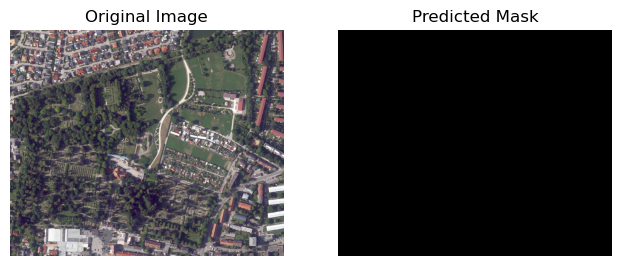

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(new_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_val, model.predict(X_val))
precision = precision_score(y_val, model.predict(X_val))
recall = recall_score(y_val, model.predict(X_val))
f1 = f1_score(y_val, model.predict(X_val))

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [33]:
from sklearn.model_selection import cross_val_score

# 2D array for scikit-learn compatibility
X_all = features.reshape(-1, 1)
y_all = mask.ravel()

# Initialize random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

k = 5
cv_scores = cross_val_score(model, X_all, y_all, cv=k, scoring='f1')

print(f"F1 Scores for each fold: {cv_scores}")
print(f"Average F1 score: {np.mean(cv_scores)}")

F1 Scores for each fold: [nan nan nan nan nan]
Average F1 score: nan


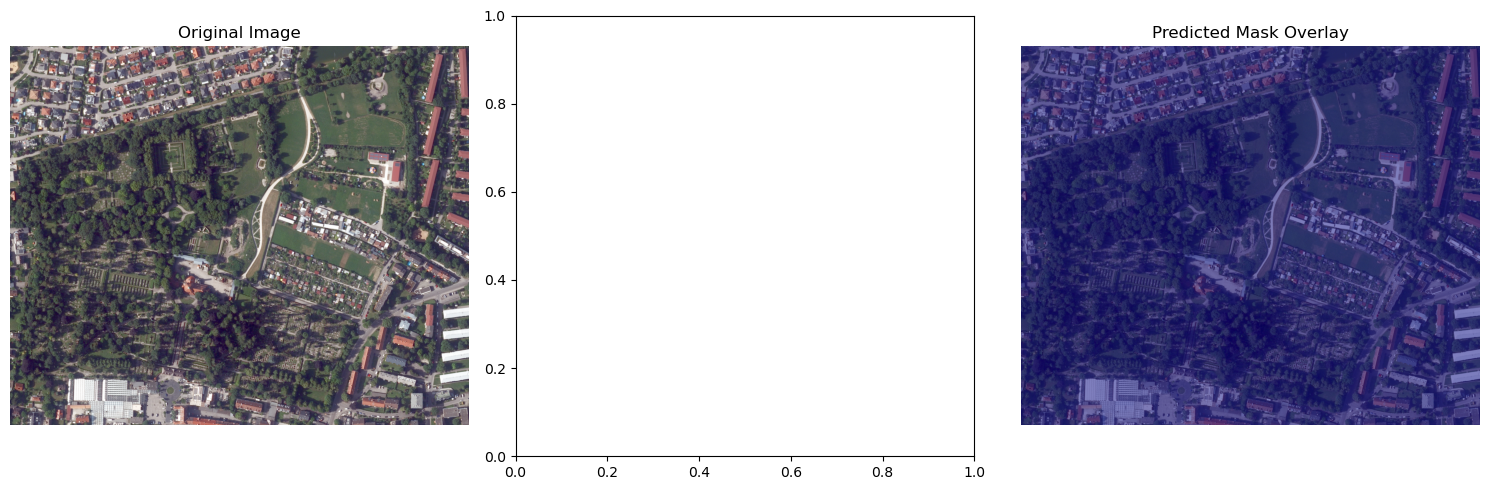

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(new_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[2].imshow(new_image)
axes[2].imshow(predicted_mask, cmap='jet', alpha=0.5) 
axes[2].set_title('Predicted Mask Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Random Forest

In [61]:
from rasterstats import zonal_stats
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from osgeo import gdal
import geopandas as gpd

In [81]:
polygons = gpd.read_file('mask_graves2.geojson')
polygons

,geometry
0,"POLYGON ((1217788.57746 6168373.56471, 1217789..."
1,"POLYGON ((1217779.62415 6168373.56471, 1217781..."
2,"POLYGON ((1217762.91130 6168370.57788, 1217765..."
3,"POLYGON ((1217784.39925 6168370.27920, 1217784..."
4,"POLYGON ((1217736.64826 6168369.98051, 1217737..."
...,...
234,"POLYGON ((1217742.61713 6168046.80521, 1217742..."
235,"POLYGON ((1217730.97783 6168047.40258, 1217731..."
236,"POLYGON ((1217744.40779 6168050.68810, 1217745..."
237,"POLYGON ((1217749.18289 6168045.01311, 1217749..."


In [76]:
from osgeo import gdal

dataset = gdal.Open('mask_graves2.tif')
crs = dataset.GetProjection()
print(crs)

PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]


In [77]:
polygons.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Found 211 shapes


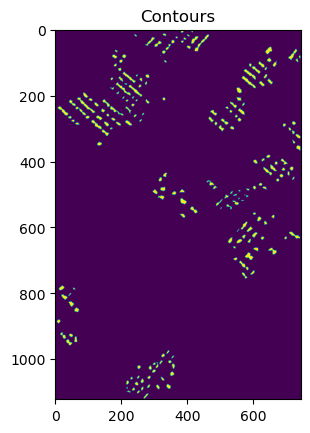

In [89]:
import cv2 as cv
import matplotlib.pyplot as plt
import rasterio

def find_contours(mask):
    cnts, hierarchy = cv.findContours(
        mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    print("Found %d shapes" % (len(cnts)))
    return cnts

def show_contours(contours, image):
    cv.drawContours(image, contours, -1, (0, 255, 0), 2)
    plt.imshow(image)
    plt.title('Contours')
    plt.show()

# Load the mask from TIFF
with rasterio.open('mask_graves2.tif') as src:
    mask = src.read(1)  # read the first band

# Convert mask to 8-bit image (expected by findContours)
mask_8bit = cv.normalize(mask, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)

# Find contours
contours = find_contours(mask_8bit)

# Display contours
show_contours(contours, mask_8bit)

In [95]:
from shapely.geometry import Polygon
import geopandas as gpd

polygons = [Polygon(np.flip(cnt.squeeze(), axis=1)) for cnt in contours if cnt.shape[0] >= 3]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons)

# Set the CRS to match your raster data (replace with the correct CRS)
gdf.crs = "EPSG:3857"  # or whatever is appropriate

# Export to Shapefile or GeoJSON
gdf.to_file("data/corrected_output_polygons.shp")
gdf.to_file("data/corrected_output_polygons.geojson", driver='GeoJSON')

In [86]:
raster_path = 'Images/Image_bbox3.tif'
mask_path = 'mask_graves2.tif'

In [42]:
mask_ds = gdal.Open(mask_path)
band = mask_ds.GetRasterBand(1)
drv = gdal.GetDriverByName('ESRI Shapefile')
out_shp = '/mnt/data/mask_polygons.shp'
gdal.Polygonize(band, None, drv.CreateDataSource(out_shp), -1, [], callback=None)

AttributeError: 'Driver' object has no attribute 'CreateDataSource'